In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import roc_curve, auc
sns.set_style('ticks')

RANDOM_SEEDS = 20090425, 19700309

In [3]:
DATA_DIR = '../data/'

## Import and clean data

In [4]:
kawasaki_raw = pd.read_csv(DATA_DIR + 'KawasakiDisease_DATA vBP04.28.2017.csv', 
                           parse_dates=['dob', 'date_admission', 'date_discharge'], 
                           index_col=0)
kawasaki_raw.head()

,mrn,patient_initials,sex,dob,age_years,age_months,race,race_specify,ethnicity,asian_specify,...,echo2_criteria_level,echo_3_specify___10,echo3_criteria_level,echo1_ectasia_aneurysm,echo2_ectasia_aneurysm,echo3_ectasia_aneurysm,echo_positive,kdlevel,kd,kdclass
study_id,,,,,,,,,,,,,,,,,,,,,
KD001,23640436,SA,0,2004-12-06,6.080892,72.970695,0,NaN,1,NaN,...,0,0,0,1,0,0,1,6.0,1,2.0
KD003,30914774,OB,1,2009-01-09,0.969219,11.630629,4,NaN,1,NaN,...,1,0,0,0,1,1,1,1.0,1,1.0
KD004a,21827407,JB,1,2003-05-08,1.456567,17.478798,3,NaN,1,NaN,...,0,0,0,0,0,0,1,1.0,1,1.0
KD005,16903700,AB,1,1997-09-10,6.491692,77.900299,4,NaN,2,NaN,...,0,0,0,1,1,0,1,1.0,1,1.0
KD006,25177965,GB,1,2005-01-20,1.130756,13.569067,4,NaN,2,NaN,...,0,0,0,0,0,0,0,1.0,1,1.0


In [5]:
assert kawasaki_raw.index.is_unique

In [6]:
race_lookup = {0: "American Indian/Alaska Native",   
1: "Asian",     
2: "Native Hawaiian or Other Paci c Islander",    
3: "Black or African American",    
4: "White",    
5: "More Than One Race",    
6: "Unknown / Not Reported",    
7: "Declined",   
8: "Hispanic",      
9: "Other"}

In [7]:
kawasaki_raw.assign(Race=kawasaki_raw.race.replace(race_lookup)).groupby('Race').size()

Race
American Indian/Alaska Native      2
Asian                             20
Black or African American        109
More Than One Race                 3
Other                             17
White                            299
dtype: int64

In [8]:
kawasaki_raw['therapy_nonresponder'] = (kawasaki_raw.therapy_response___1==1).astype(int)
kawasaki_raw.therapy_nonresponder.value_counts()

0    378
1     72
Name: therapy_nonresponder, dtype: int64

Calculate age from admission year and birth year

In [9]:
kawasaki_raw['age_months'] = (kawasaki_raw.date_admission - kawasaki_raw.dob).dt.days/30.
kawasaki_raw['age_months'].head()

study_id
KD001     74.033333
KD003     11.800000
KD004a    17.733333
KD005     79.033333
KD006     13.766667
Name: age_months, dtype: float64

In [10]:
kawasaki_raw['age_years'] = (kawasaki_raw.age_months/12.).astype(int)

In [11]:
kawasaki_raw['age_norm'] = ((kawasaki_raw.age_months - kawasaki_raw.age_months.mean())
                            /kawasaki_raw.age_months.std())

In [12]:
kawasaki_raw['age_norm2'] = kawasaki_raw['age_norm']**2

In [13]:
kawasaki_raw['age_under1'] = (kawasaki_raw.age_years==0).astype(int)
kawasaki_raw['age_4over'] = (kawasaki_raw.age_years>=4).astype(int)

In [14]:
kawasaki_raw['other_race'] = (~kawasaki_raw.race.isin([3,4])).astype(int)

In [15]:
kawasaki_raw['black'] = (kawasaki_raw.race==3).astype(int)

In [16]:
kawasaki_raw['aneurysm'] = (kawasaki_raw.abnormality___2==1).astype(int)
kawasaki_raw['ectasia'] = (kawasaki_raw.abnormality___1==1).astype(int)
kawasaki_raw['ectasia_or_aneurysm'] = (kawasaki_raw.aneurysm | kawasaki_raw.ectasia).astype(int)

In [17]:
kawasaki_raw.loc[:, 'completekd'] = (kawasaki_raw.completekd==1).astype(int)

Potential covariates: hemoglobin, albumin, platelets, esr, crp, white count, alt, days of fever/days of illness, ast, sodium

In [18]:
relevant_cols = ['therapy_nonresponder', 'sex', 'age_under1','age_4over', 'age_years',
                 'black', 'other_race', 'ethnicity', 'completekd', 'hgb', 'albumin', 
                 'esr_mm_hr', 'plts', 'crp_mg_l', 'wbc', 'ast', 'illness_day_at_rx', 
                 'aneurysm', 'ectasia', 'ectasia_or_aneurysm']

In [19]:
kawasaki_subset = (kawasaki_raw.loc[kawasaki_raw.kdclass!=3, relevant_cols]
                           .rename(columns={'sex':'male'}))
kawasaki_subset.head()

,therapy_nonresponder,male,age_under1,age_4over,age_years,black,other_race,ethnicity,completekd,hgb,albumin,esr_mm_hr,plts,crp_mg_l,wbc,ast,illness_day_at_rx,aneurysm,ectasia,ectasia_or_aneurysm
study_id,,,,,,,,,,,,,,,,,,,,
KD001,0,0,0,1,6,0,1,1,0,11.4,3.0,NaN,209.0,24.000000,3.700000,68.0,6,0,1,1
KD003,1,1,1,0,0,0,0,1,1,7.7,2.1,98.0,188.0,241.100010,7.300000,29.0,6,0,0,0
KD004a,1,1,0,0,1,1,0,1,1,11.1,NaN,22.0,332.0,NaN,19.500000,NaN,3,0,0,0
KD005,0,1,0,1,6,0,0,2,1,14.1,3.3,65.0,281.0,192.000000,22.799999,43.0,8,0,1,1
KD006,0,1,0,0,1,0,0,2,1,10.0,3.5,62.0,507.0,48.099998,27.000000,31.0,9,0,0,0


In [20]:
kawasaki_subset.shape

(450, 20)

Responder proportion by race

In [21]:
kawasaki_subset.groupby('black').therapy_nonresponder.mean()

black
0    0.137830
1    0.229358
Name: therapy_nonresponder, dtype: float64

Probability of responder does not seem to vary with age. Wide variation at the end is mostly a sample size artefact.

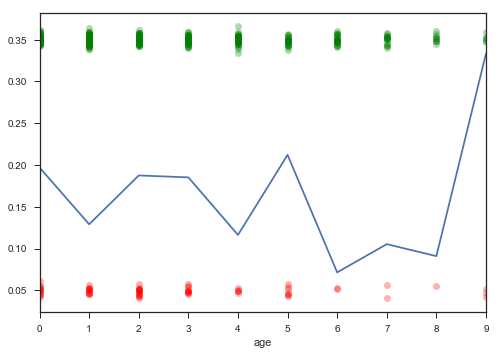

In [22]:
ax = (kawasaki_subset[kawasaki_subset.age_years<10]
              .assign(age_int=kawasaki_subset.age_years.astype(int))
              .groupby('age_int')).therapy_nonresponder.mean().plot()
ax.set_xlabel('age')
responders = kawasaki_subset[kawasaki_subset.therapy_nonresponder==0]
ax.plot(responders.age_years, np.random.normal(0.35, 0.005, size=len(responders)), 
        'go', alpha=0.3)

nonresponders = kawasaki_subset[kawasaki_subset.therapy_nonresponder==1]
ax.plot(nonresponders.age_years, np.random.normal(0.05, 0.005, size=len(nonresponders)), 
        'ro', alpha=0.3)

Proportion of null values for each variable

In [23]:
kawasaki_subset.isnull().mean().round(2)

therapy_nonresponder    0.00
male                    0.00
age_under1              0.00
age_4over               0.00
age_years               0.00
black                   0.00
other_race              0.00
ethnicity               0.00
completekd              0.00
hgb                     0.07
albumin                 0.41
esr_mm_hr               0.11
plts                    0.06
crp_mg_l                0.24
wbc                     0.06
ast                     0.21
illness_day_at_rx       0.00
aneurysm                0.00
ectasia                 0.00
ectasia_or_aneurysm     0.00
dtype: float64

Scatterplot of continuous covariates

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


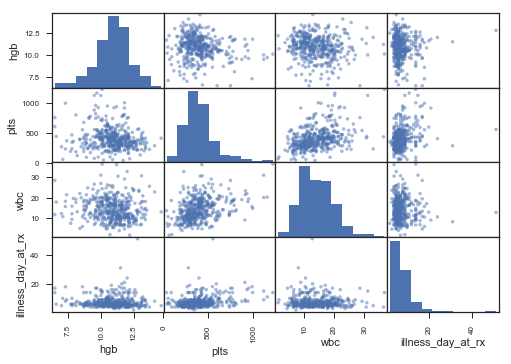

In [24]:
pd.scatter_matrix(kawasaki_subset[['hgb', 'plts', 'wbc', 'illness_day_at_rx']]);

## Model specification

### Expanded covariate model

This expanded model imputes missing values for `hgb`, `plts` and `wbc`, and uses normalized variables. The age effect has been removed.

In [25]:
binary_covs = ['male', 'black', 'completekd', 'ectasia', 'aneurysm']

kawasaki_subset[binary_covs].isnull().mean()

male          0.0
black         0.0
completekd    0.0
ectasia       0.0
aneurysm      0.0
dtype: float64

In [26]:
from sklearn.preprocessing import scale
import theano.tensor as tt

k = len(binary_covs) + 6

regularize = False

y = kawasaki_subset.therapy_nonresponder.values

with pm.Model() as covariate_model:
    
    # Imputation of missing values
    hgb_norm = (kawasaki_subset.hgb - kawasaki_subset.hgb.mean()) / (2*kawasaki_subset.hgb.std())
    hgb_imp = pm.Normal('hgb_imp', 0, sd=0.5, observed=hgb_norm)
    
    plts_norm = (kawasaki_subset.plts - kawasaki_subset.plts.mean()) / (2*kawasaki_subset.plts.std())
    plts_imp = pm.Normal('plts_imp', 0, sd=0.5, observed=plts_norm)
    
    wbc_norm = (kawasaki_subset.wbc - kawasaki_subset.wbc.mean()) / (2*kawasaki_subset.wbc.std())
    wbc_imp = pm.Normal('wbc_imp', 0, sd=0.5, observed=wbc_norm)
    
    crp_norm = (kawasaki_subset.crp_mg_l - kawasaki_subset.crp_mg_l.mean()) / (2*kawasaki_subset.crp_mg_l.std()) 
    crp_imp = pm.Normal('crp_imp', 0, sd=0.5, observed=crp_norm)
    
    ast_norm = (kawasaki_subset.ast - kawasaki_subset.ast.mean()) / (2*kawasaki_subset.ast.std()) 
    ast_imp = pm.Normal('ast_imp', 0, sd=0.5, observed=ast_norm)
    
    esr_norm = (kawasaki_subset.esr_mm_hr - kawasaki_subset.esr_mm_hr.mean()) / (2*kawasaki_subset.esr_mm_hr.std()) 
    esr_imp = pm.Normal('esr_imp', 0, sd=0.5, observed=esr_norm)
    
    illness_day_norm = ((kawasaki_subset.illness_day_at_rx - kawasaki_subset.illness_day_at_rx.mean()) 
                                / (2*kawasaki_subset.illness_day_at_rx.std()))
    
    # Baseline probability of non-response
    θ = pm.Normal('θ', 0, sd=10)
    
    if regularize:
        # Horseshoe parameters
        λ = pm.HalfCauchy('λ', 1, shape=k)
        τ = pm.HalfCauchy('τ', 1)

        # Coefficients for covariates
        β = pm.Normal('β', 0, sd=λ*τ, shape=k)
        X = scale(kawasaki_subset[binary_covs].values)
    else:
        β = pm.Normal('β', 0, sd=10, shape=k)
        X = kawasaki_subset[binary_covs].values
    
    odds = pm.Deterministic('odds', tt.exp(β))
        
    π = pm.Deterministic('π', pm.invlogit(θ + tt.dot(X, β[:-6]) 
            + β[-6]*esr_imp 
            + β[-5]*ast_imp 
            + β[-4]*crp_imp
            + β[-3]*hgb_imp 
            + β[-2]*plts_imp 
            + β[-1]*wbc_imp))
    
    non_responder = pm.Bernoulli('non_responder', π, observed=y)
    
    brier = pm.Deterministic('brier_score', tt.mean((π - y)**2))

In [27]:
with covariate_model:
    cov_trace = pm.sample(5000, n_init=50000, tune=4000, #target_accept=0.9,
                          random_seed=RANDOM_SEEDS[0])

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 1,948.6:  24%|██▍       | 11913/50000 [00:07<00:34, 1089.51it/s]
Convergence archived at 12000
Interrupted at 12,000 [24%]: Average Loss = 1,983.9
100%|██████████| 9000/9000 [06:54<00:00, 21.69it/s] 


Convergence diagnostic plot

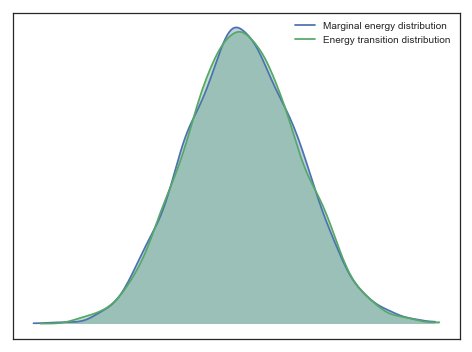

In [29]:
pm.energyplot(cov_trace)

Odds ratios with credible intervals

In [28]:
pm.summary(cov_trace[-1000:], varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.366            0.442            0.013            [0.615, 2.244]
  1.701            0.547            0.014            [0.738, 2.754]
  0.848            0.251            0.008            [0.415, 1.360]
  1.178            0.421            0.010            [0.435, 2.005]
  2.899            2.308            0.064            [0.236, 7.335]
  1.205            0.422            0.011            [0.505, 2.003]
  1.316            0.346            0.009            [0.667, 1.964]
  1.918            0.632            0.017            [0.835, 3.118]
  0.613            0.182            0.004            [0.303, 0.979]
  0.624            0.218            0.006            [0.287, 1.050]
  1.926            0.623            0.016            [0.842, 3.178]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |-------

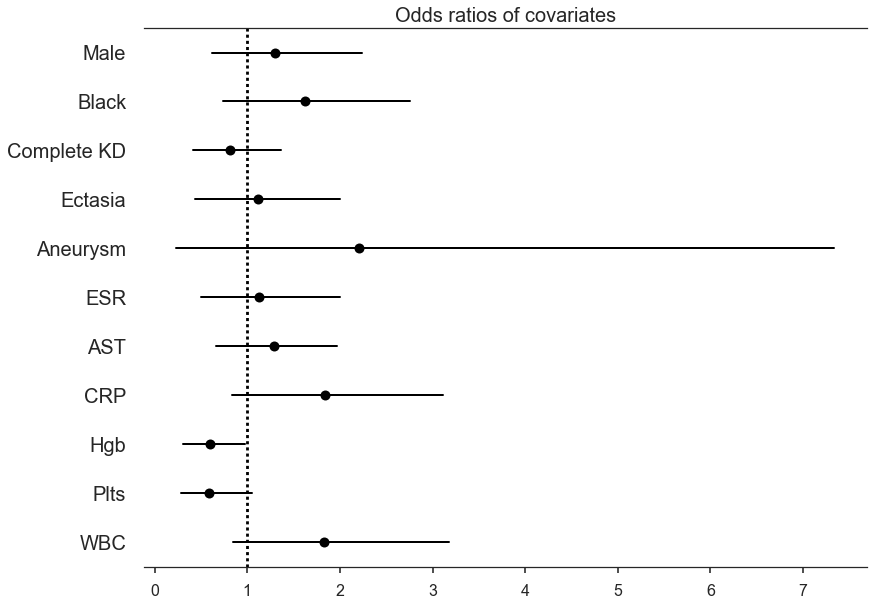

In [29]:
pm.forestplot(cov_trace[-1000:], 
              varnames=['odds'], 
              ylabels=['Male', 'Black', 'Complete KD', 'Ectasia', 'Aneurysm',
                       'ESR', 'AST', 'CRP', 'Hgb', 'Plts', 'WBC'], 
              vline=1, 
              main='Odds ratios of covariates',
              quartiles=False, linewidth=5, fontsize=20, color='black', markersize=10)


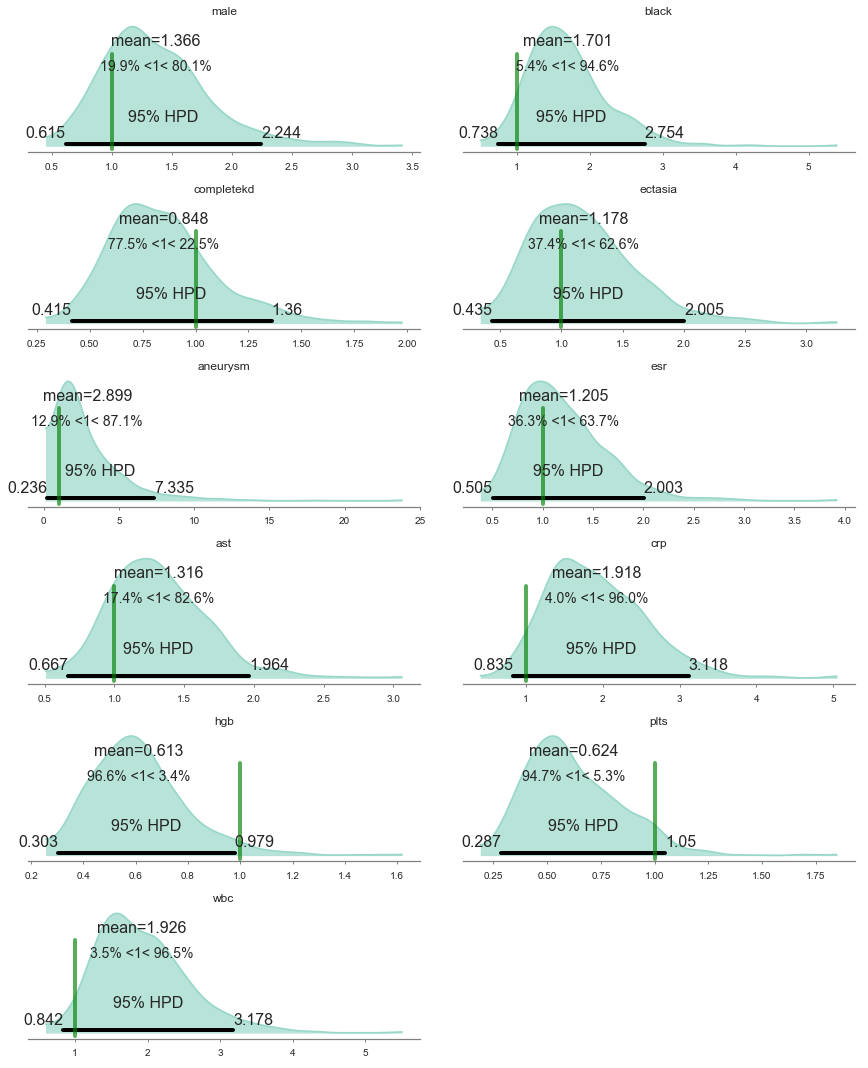

In [32]:
from pymc3 import plot_posterior

axes = plot_posterior(cov_trace[-1000:], kde_plot=True,
              varnames=['odds'], ref_val=1, color='#99d8c9', shade=True, alpha=0.7)

for ax,name in zip(axes, binary_covs + ['esr', 'ast', 'crp', 'hgb', 'plts', 'wbc']):
    ax.set_title(name);

Posterior baseline probability of non-response

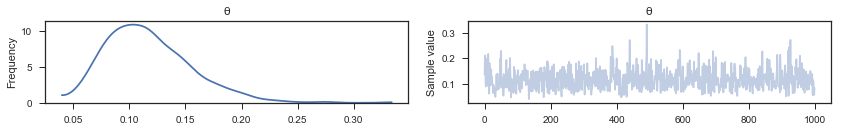

In [33]:
pm.traceplot(cov_trace[-1000:], varnames=['θ'], transform=lambda x: 1/(1+np.exp(-x)));

Probability that black odds ratio is greater than one

In [41]:
(cov_trace['odds', -1000:][:, 1] > 1).mean().round(3)

0.94599999999999995

probability it is greater than two

In [30]:
(cov_trace['odds', -1000:][:, 1] > 2).mean().round(3)

0.23999999999999999

Estimate of brier score

array([<matplotlib.axes._subplots.AxesSubplot object at 0x139726668>], dtype=object)

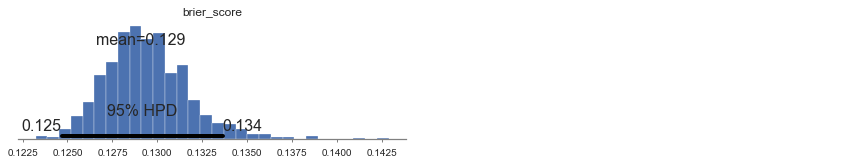

In [34]:
pm.plot_posterior(cov_trace[-1000:], varnames=['brier_score'])

In [32]:
probs = cov_trace['π']
predictions = pd.DataFrame({'p': probs.mean(0),
                            'obs': kawasaki_subset.therapy_nonresponder})

In [33]:
fpr, tpr, thresh = roc_curve(predictions.obs, predictions.p)
roc_auc = auc(fpr, tpr)

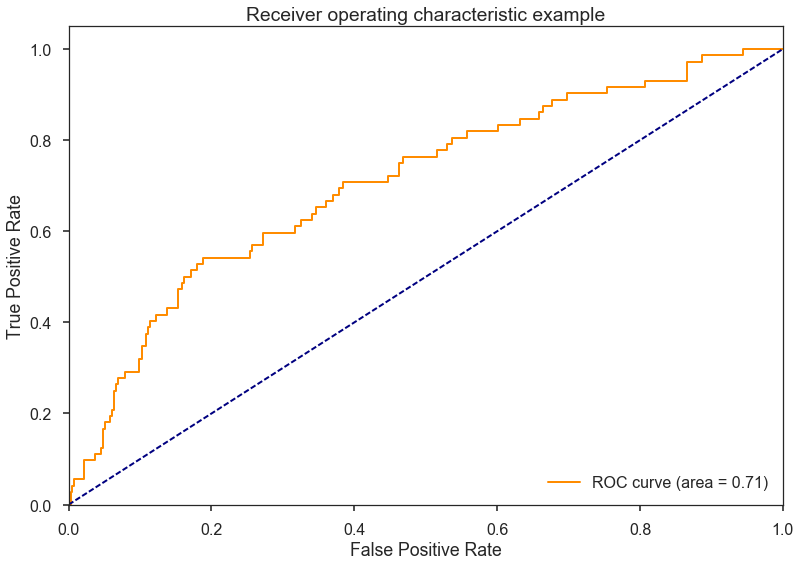

In [34]:
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")